In [2]:
import numpy as np
import pandas as pd


# 创建测试信号
def create_test_signal(duration=1.0, sample_rate=360):
    # 时间点
    t = np.arange(0, duration, 1/sample_rate)
    
    # 创建100Hz、200Hz和300Hz的正弦信号，加入一些噪声
    signal_100hz = 1 * np.sin(2 * np.pi * 100 * t)  # 100Hz基频
    signal_200hz = 0.3 * np.sin(2 * np.pi * 200 * t)  # 200Hz谐波
    signal_300hz = 0.3 * np.sin(2 * np.pi * 300 * t)  # 300Hz信号
    noise = 0.05 * np.random.randn(len(t))
    
    # 组合信号
    signal = signal_100hz + signal_200hz + signal_300hz + noise
    
    # 创建时间戳（毫秒）
    timestamps = (t * 1000).astype(int) + 6040  # 从6040开始
    
    # 创建DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'X_Acceleration': signal,
        'Y_Acceleration': signal * 0.8,  # Y方向稍微弱一些
        'Z_Acceleration': signal * 0.6   # Z方向更弱
    })
    
    return df

# 创建数据
df = create_test_signal(duration=0.15)  # 150ms的数据

# 保存到CSV文件
df.to_csv('test_100hz.csv', index=False)

# 显示前几行数据
print("data preview:")
print(df.head())

# 打印数据统计信息
print("\ndata statistics:")
print(f"data points: {len(df)}")
print(f"time range: {df['Timestamp'].min()} - {df['Timestamp'].max()} ms")
print(f"sampling rate: {1000 * len(df) / (df['Timestamp'].max() - df['Timestamp'].min()):.2f} Hz")

data preview:
   Timestamp  X_Acceleration  Y_Acceleration  Z_Acceleration
0       6040       -0.049615       -0.039692       -0.029769
1       6042        0.651258        0.521006        0.390755
2       6045       -0.393739       -0.314991       -0.236243
3       6048       -1.117919       -0.894335       -0.670751
4       6051        1.328718        1.062974        0.797231

data statistics:
data points: 54
time range: 6040 - 6187 ms
sampling rate: 367.35 Hz


Nyquist频率: 500.0 Hz


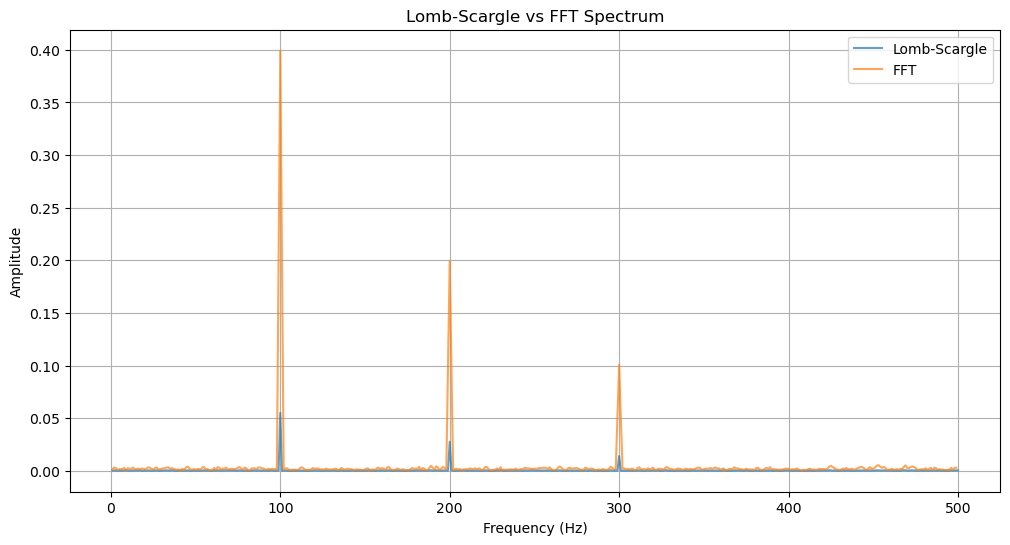

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

def perform_spectral_analysis(data, sampling_rate):
    # 确保采样率足够高
    nyquist = sampling_rate / 2
    print(f"Nyquist频率: {nyquist} Hz")
    
    # 创建测试信号
    t = np.arange(0, len(data)) / sampling_rate
    
    # 使用汉宁窗减少泄漏
    window = np.hanning(len(data))
    data_windowed = data * window
    
    # 执行FFT
    N = len(data)
    yf = np.fft.fft(data_windowed)
    xf = np.fft.fftfreq(N, 1/sampling_rate)[:N//2]
    
    # 计算幅值谱
    amp = 2.0/N * np.abs(yf[1:N//2])
    
    # Lomb-Scargle
    freqs_ls = np.linspace(1, nyquist, N//2)
    pgram = lombscargle(t, data, 2 * np.pi * freqs_ls, normalize=True)
    amp_ls = np.sqrt(4 * pgram / N)
    
    return xf[1:], amp, freqs_ls, amp_ls

# 生成测试信号
sampling_rate = 1000  # 提高采样率到1000Hz
duration = 1.0
t = np.arange(0, duration, 1/sampling_rate)

# 生成信号
signal_100hz = 0.8 * np.sin(2 * np.pi * 100 * t)
signal_200hz = 0.4 * np.sin(2 * np.pi * 200 * t)
signal_300hz = 0.2 * np.sin(2 * np.pi * 300 * t)
noise = 0.05 * np.random.randn(len(t))

# 组合信号
signal = signal_100hz + signal_200hz + signal_300hz + noise

# 进行频谱分析
freqs_fft, amp_fft, freqs_ls, amp_ls = perform_spectral_analysis(signal, sampling_rate)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(freqs_ls, amp_ls, label='Lomb-Scargle', alpha=0.7)
plt.plot(freqs_fft, amp_fft, label='FFT', alpha=0.7)
plt.title('Lomb-Scargle vs FFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

Nyquist频率: 500.0 Hz


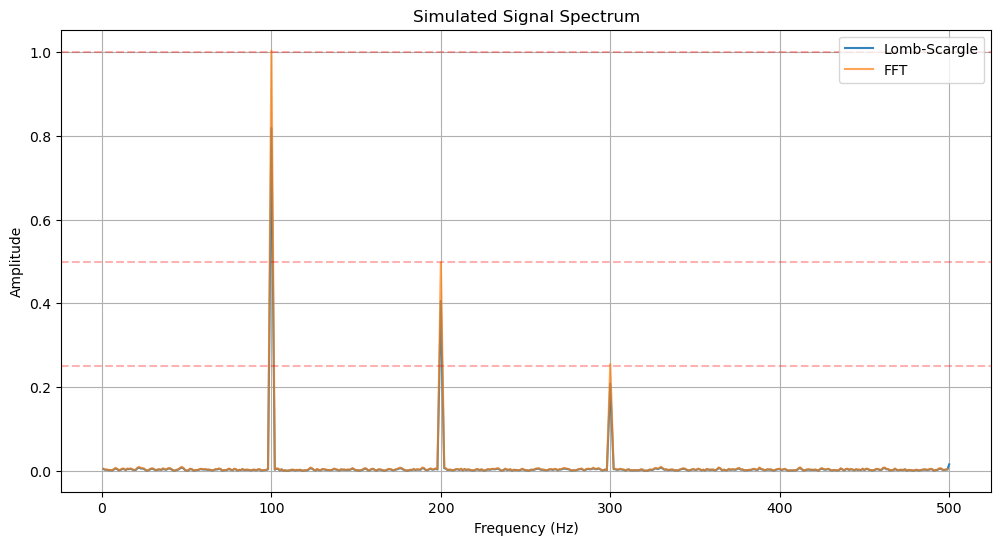

In [5]:
def perform_spectral_analysis(data, sampling_rate):
    # 确保采样率足够高
    nyquist = sampling_rate / 2
    print(f"Nyquist频率: {nyquist} Hz")
    
    t = np.arange(0, len(data)) / sampling_rate
    N = len(data)
    
    # 使用相同的窗函数
    window = np.hanning(N)
    data_windowed = data * window
    
    # FFT分析
    yf = np.fft.fft(data_windowed)
    xf = np.fft.fftfreq(N, 1/sampling_rate)[:N//2]
    
    # 修改FFT归一化方法
    amp_fft = np.abs(yf[1:N//2]) * 2.0 / (N * np.sum(window)/N)
    
    # Lomb-Scargle分析
    freqs_ls = np.linspace(1, nyquist, N//2)
    pgram = lombscargle(t, data_windowed, 2 * np.pi * freqs_ls)
    
    # 修改Lomb-Scargle归一化方法
    amp_ls = np.sqrt(4 * pgram / (N * np.sum(window**2)/N))
    
    return xf[1:], amp_fft, freqs_ls, amp_ls

# 生成测试信号
sampling_rate = 1000  # 1kHz采样率
duration = 1.0
t = np.arange(0, duration, 1/sampling_rate)

# 生成已知振幅的信号
signal_100hz = 1.0 * np.sin(2 * np.pi * 100 * t)  # 振幅1.0
signal_200hz = 0.5 * np.sin(2 * np.pi * 200 * t)  # 振幅0.5
signal_300hz = 0.25 * np.sin(2 * np.pi * 300 * t) # 振幅0.25
noise = 0.05 * np.random.randn(len(t))

# 组合信号
signal = signal_100hz + signal_200hz + signal_300hz + noise

# 进行频谱分析
freqs_fft, amp_fft, freqs_ls, amp_ls = perform_spectral_analysis(signal, sampling_rate)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(freqs_ls, amp_ls, label='Lomb-Scargle', alpha=0.9)
plt.plot(freqs_fft, amp_fft, label='FFT', alpha=0.7)
plt.title('Simulated Signal Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# 添加真实振幅标记
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.3)

plt.show()

Nyquist频率: 250.0 Hz


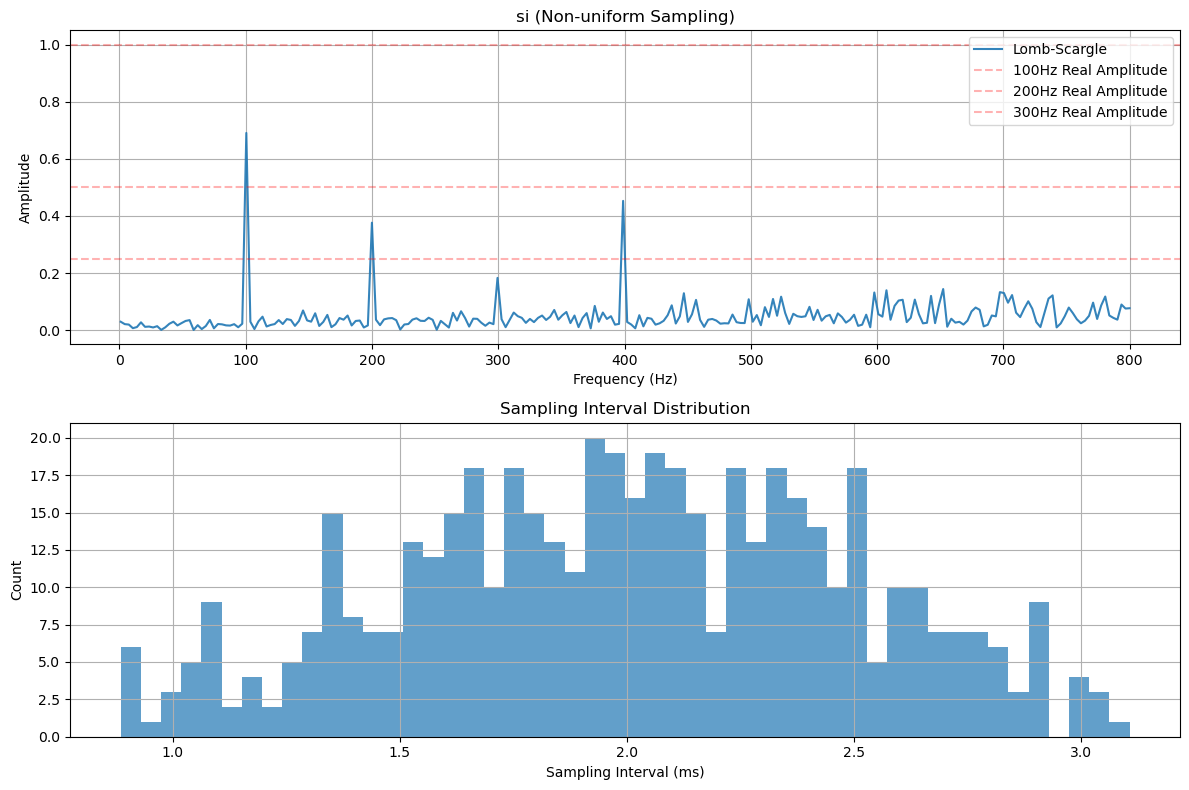


Sampling Statistics:
Average Sampling Interval: 2.003 ms
Sampling Interval Standard Deviation: 0.490 ms
Minimum Sampling Interval: 0.885 ms
Maximum Sampling Interval: 3.107 ms


In [14]:
import numpy as np
import pandas as pd
from scipy.signal import lombscargle
import matplotlib.pyplot as plt

def create_nonuniform_signal(mean_sample_rate=1000, duration=1.0, jitter_factor=0.3):
    """
    生成非均匀采样的测试信号
    
    参数:
    mean_sample_rate: 平均采样率
    duration: 信号持续时间
    jitter_factor: 时间抖动因子 (0-1之间，0表示均匀采样)
    """
    # 生成基础时间点
    n_samples = int(mean_sample_rate * duration)
    base_times = np.linspace(0, duration, n_samples)
    
    # 添加随机时间抖动
    jitter = np.random.uniform(-jitter_factor/mean_sample_rate, 
                             jitter_factor/mean_sample_rate, 
                             n_samples)
    times = base_times + jitter
    times.sort()  # 确保时间序列递增
    
    # 生成信号
    signal_100hz = 1.0 * np.sin(2 * np.pi * 100 * times)  # 振幅1.0
    signal_200hz = 0.5 * np.sin(2 * np.pi * 200 * times)  # 振幅0.5
    #signal_300hz = 0.25 * np.sin(2 * np.pi * 300 * times) # 振幅0.25
    noise = 0.05 * np.random.randn(len(times))
    
    # 组合信号
    signal = signal_100hz + signal_200hz + noise
    
    return times, signal

def perform_spectral_analysis(times, signal, mean_sample_rate):
    """
    对非均匀采样信号进行频谱分析
    """
    N = len(signal)
    nyquist = mean_sample_rate / 2
    print(f"Nyquist频率: {nyquist} Hz")
    
    # 使用窗函数
    window = np.hanning(N)
    signal_windowed = signal * window
    
    # Lomb-Scargle分析
    freqs_ls = np.linspace(1, 800, N//2)
    pgram = lombscargle(times, signal_windowed, 2 * np.pi * freqs_ls)
    amp_ls = np.sqrt(4 * pgram / (N * np.sum(window**2)/N))
    
    # 计算采样间隔分布
    dt = np.diff(times)
    
    return freqs_ls, amp_ls, dt

# 生成非均匀采样信号
mean_sample_rate = 500  # 平均采样率2kHz
duration = 1.0
times, signal = create_nonuniform_signal(mean_sample_rate, duration, jitter_factor=0.3)

# 进行频谱分析
freqs_ls, amp_ls, dt = perform_spectral_analysis(times, signal, mean_sample_rate)

# 绘制频谱
plt.figure(figsize=(12, 8))

# 频谱图
plt.subplot(2, 1, 1)
plt.plot(freqs_ls, amp_ls, label='Lomb-Scargle', alpha=0.9)
plt.title('si (Non-uniform Sampling)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# 添加真实振幅标记
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.3, label='100Hz Real Amplitude')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='200Hz Real Amplitude')
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.3, label='300Hz Real Amplitude')
plt.legend()
# 采样间隔分布直方图
plt.subplot(2, 1, 2)
plt.hist(dt * 1000, bins=50, alpha=0.7)
plt.title('Sampling Interval Distribution')
plt.xlabel('Sampling Interval (ms)')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()

plt.show()

# 打印采样统计信息
print(f"\nSampling Statistics:")
print(f"Average Sampling Interval: {np.mean(dt)*1000:.3f} ms")
print(f"Sampling Interval Standard Deviation: {np.std(dt)*1000:.3f} ms")
print(f"Minimum Sampling Interval: {np.min(dt)*1000:.3f} ms")
print(f"Maximum Sampling Interval: {np.max(dt)*1000:.3f} ms")